# Describing an Optical System with Detailed Aperture and Wavefront Error Definitions

## Introduction

While the `Optics` class offers a way to define some optical parameters, a more detailed definition leading to the Point Spread Function or the Modulation Transfer Function is possible.

To this end, a [Pupil Function](https://en.wikipedia.org/wiki/Pupil_function) or an Aperture Function will be defined, using an Amplitude through the aperture and a Wavefront Error.

The aperture can be a simple circular one, or with an obscuration and even with spiders to hold the secondary mirror in place. The Amplitude (through the aperture) simply describes how much light is let in, therefore it is the Amplitude at each point on the aperture.

The Wavefront Error (WFE) is defined by one or more polynomials (e.g., Zernike), describing optical imperfections like coma or defocus.

The Aperture or Pupil Function combines this complex aperture definition and the WFE, and is handled by [`prysm`](https://prysm.readthedocs.io).

For this example we will use the Pléiades optics and the wavelength range for the PAN band.

## Loading the Optics Parameters

We have to start with the opticks package import.

In [12]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", ".."))
    os.getcwd()

In [13]:
from opticks import u

# pint support to matplotlib
u.setup_matplotlib()

In [14]:
from pathlib import Path

from opticks.imager_model.detector import Channel, Detector
from opticks.imager_model.optics import Optics

# print(f"current working directory: {Path.cwd()}")

file_directory = Path("docs", "examples", "sample_sat_pushbroom")
optics_file_path = file_directory.joinpath("optics.yaml")
detector_file_path = file_directory.joinpath("pan_detector.yaml")

# check whether input files exist
print(
    f"optics file:  [{optics_file_path}] (file exists:  {optics_file_path.is_file()})"
)
print(
    f"detector file:  [{detector_file_path}] (file exists:  {detector_file_path.is_file()})"
)

# Init opt,ics object
optics = Optics.from_yaml_file(optics_file_path)
detector = Detector.from_yaml_file(detector_file_path)

# select the PAN channel
band_id = "pan"
channel: Channel = detector.params.channels.all[band_id]

optics file:  [docs/examples/sample_sat_pushbroom/optics.yaml] (file exists:  True)
detector file:  [docs/examples/sample_sat_pushbroom/pan_detector.yaml] (file exists:  True)


## Defining the Complex Aperture

Now that the optics data is loaded, we have to define the complex aperture. Pléiades has an optical diameter of 650 mm and the secondary mirror has a diameter that is 30% of the total aperture size.

aperture diameter: 650 mm
aperture samples: 400
aperture sample spacing: 1.625 mm


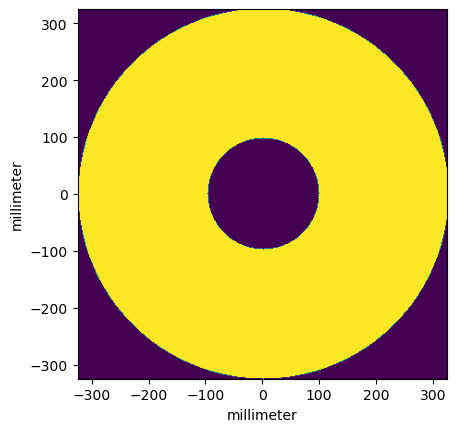

In [15]:
from opticks.imager_model.optics import ApertureFactory

%matplotlib inline

from matplotlib import pyplot as plt

# Generate the aperture model
# ---------------------------
# aperture sample size (per side)
samples = 400

# 30% obscuration for Pléiades
obscuration_ratio = 0.3

# generate the grid and the aperture
# for grid r in mm and t in radians
aperture,grid = ApertureFactory.circle_aperture_with_obscuration(optics.params.aperture_diameter, obscuration_ratio, samples, with_units=True)

# set the aperture in the Optics model
optics.set_aperture_model(aperture)

print(f"aperture diameter: {optics.params.aperture_diameter:~P}")
print(f"aperture samples: {samples}")
# sample spacing of the aperture definition
# implicitly assumes samples is int and not (int, int)
print(f"aperture sample spacing: {optics.aperture_dx:~P}")

half_ext = samples / 2 * optics.aperture_dx

# visualise the aperture model
# also possible to initialise a RichData object and use plot2d()
plt.imshow(aperture, origin="lower", aspect="equal", extent=[-half_ext, half_ext, -half_ext, half_ext])

The aperture model is simply an `ndarray` mask that is `True` or `False` for each "sample" of the aperture, depending on whether the light can pass or not. It can also be expressed as an `ndarray` of floats (0.0 and 1.0).


## Defining the Wavefront Error and the Aperture/Pupil Function

### Setting up the Wavefront Aberration Function

The Wavefront Aberration Function or the Optical Path Difference (OPD) is a property of the optical system that is computed via Zemax models or actual measurements. It is expressed in terms of WFE RMS coefficients (either in absolute values or in fraction of wavelengths) and Zernike Polynomials to a certain order, corresponding to various aberration types. There are also other polynomial types offered by `prysm`. These coefficients should be defined for each wavelength and for each point on the image plane.

In this example we divide the bandwidth into 11 discrete wavelengths (which will be useful later for Polychromatic WFE), and assign the same set of coefficients to all wavelengths. This uniform set of coefficients is not a very realistic assumption, but is good enough for this tutorial.

We define the set of coefficients in ANSI order. In this example we have 9 coefficients corresponding to mode 8 or up to and including (n,m) = (3,1). These coefficients are defined as a fraction of the relevant wavelength. We then list the aberrations.

In [16]:
import numpy as np
from pint import Quantity

from prysm.polynomials import ansi_j_to_nm, nm_to_name

from opticks.imager_model.optics import zernike_opd

print(f"wavelength range : {channel.cuton_wvl:~P} - {channel.cutoff_wvl:~P}")
print(f"bandwidth in wavelength : {channel.bandwidth:~P}")

# divide bandwidth into 11 discrete wavelengths
wvls = Quantity.tolist(np.linspace(channel.cuton_wvl, channel.cutoff_wvl, 11))

# use a fixed WFE RMS Wavelength fraction for all wavelengths, though this is not realistic.
# the order is in ANSI, number of elements depends on the mode
wfe_rms_pct_ansi = [0.02, 0.01, 0.008, 0.02, 0.15, 0.01, 0.03, 0.04, 0.09]

# construct a dict of the wavelengths and corresponding error fractions for each zernike
wfe_rms_data = {wvl: wfe_rms_pct_ansi for wvl in wvls}

# display the WFE RMS coefficients and the total WFE RMS
print("\n---\n")
print(f"WFE RMS coeffs @ {wvls[5]:~P} (in wavelength) : {wfe_rms_data[wvls[5]]}")
print(
    f"WFE RMS coeffs @ {wvls[5]:~P} (absolute)      : {wvls[5] * wfe_rms_data[wvls[5]]:~P}"
)

w_rms_total = np.sqrt(np.sum(np.square(wvls[5] * wfe_rms_data[wvls[5]])))
print(f"WFE RMS total : {w_rms_total:~P.4} ({w_rms_total/wvls[5]:~P.4} in wavelengths)")
print("\n---\n")

# mode n = (n+1) elements
elems = len(wfe_rms_pct_ansi)

# Generate the (n,m) tuples in ANSI order
nms = [ansi_j_to_nm(i) for i in range(0, elems)]

print("Aberrations:")
print("------------")
for n, m in nms:
    print(f"{(n,m)} : {nm_to_name(n, m)}")

wavelength range : 480 nm - 820 nm
bandwidth in wavelength : 340 nm

---

WFE RMS coeffs @ 650.0 nm (in wavelength) : [0.02, 0.01, 0.008, 0.02, 0.15, 0.01, 0.03, 0.04, 0.09]
WFE RMS coeffs @ 650.0 nm (absolute)      : [13.0 6.5 5.2 13.0 97.5 6.5 19.5 26.0 58.5] nm
WFE RMS total : 120.1 nm (0.1848 in wavelengths)

---

Aberrations:
------------
(0, 0) : Piston
(1, -1) : Tilt Y
(1, 1) : Tilt X
(2, -2) : Primary Astigmatism 45°
(2, 0) : Defocus
(2, 2) : Primary Astigmatism 00°
(3, -3) : Primary Trefoil Y
(3, -1) : Primary Coma Y
(3, 1) : Primary Coma X


The OPD can then be easily computed for a single wavelength:

In [17]:
opd = zernike_opd(
    wvls[5] * wfe_rms_data[wvls[5]], optics.params.aperture_diameter, grid
)

### Monochromatic WFE

For the Monochromatic WFE, we first evaluate the Wavefront Error (WFE) for a single wavelength in the middle of the PAN band. This is not very realistic for a broadband channel like PAN, but gives us a comparison case for the Polychromatic WFE later. On the other hand, this approach may be adequate for a channel with a narrow band.

In [18]:
# middle of the channel
ref_wvl = wvls[5]

print(f"reference wavelength: {ref_wvl:~P}")

opd_mono = zernike_opd(
    ref_wvl * wfe_rms_data[ref_wvl], optics.params.aperture_diameter, grid
)

# Generate and add the pupil function
optics.add_pupil_func(ref_wvl, opd_mono)

reference wavelength: 650.0 nm


At the final step above we generated a Pupil Function with the prescribed Optical Path Difference (OPD). We can use this Pupil Function to plot the Point Spread Function (PSF) for a single point on the PSF or Image Plane.

To this end, we need to "focus" the Wavefront at the aperture to the PSF Plane and then compute the resulting PSF. This is handled internally to the `Optics.psf()` function, but we still require some sampling parameters from the user as there is a resampling on the PSF Plane.

We start with defining the required number of samples and the sample distance in the PSF plane. Therefore, the "size" of the PSF plane is the number of samples multiplied by the sample distance.

To plot the PSF, `prysm` provides the `plot2d()` function to the `RichData` object, though it does not support units. It is a thin wrapper around the `matplotlib` `imshow()`.

Airy radius: 15.744 µm
PSF sample distance : 1.968 µm
PSF plane size : 503.8 µm (256 samples)


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='micrometer', ylabel='micrometer'>)

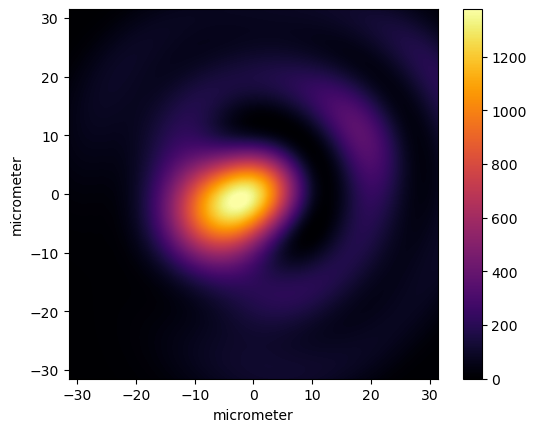

In [19]:
# Airy radius (at reference wavelength)
from prysm._richdata import RichData

airy_radius = 1.22 * ref_wvl.to(u.um) * optics.f_number

# samples within an Airy radius
Q = 8

# sample distance on the PSF plane
psf_dx = airy_radius / Q

# number of samples in the PSF plane
psf_samples = 256

# Generate the PSF
psf_mono: RichData = optics.psf(ref_wvl, psf_dx, psf_samples=psf_samples)

print(f"Airy radius: {airy_radius:~P.5}")
# print(f"psf wavelength : {psf.wavelength.to(u.nm):~P}")
print(f"PSF sample distance : {psf_mono.dx:~P.4}")
print(
    f"PSF plane size : {len(psf_mono.data) * psf_mono.dx:~P.4} ({len(psf_mono.data)} samples)"
)

# image limits
xlim = airy_radius * 2

# plot2d has fixed units corresponding to that of dx
# PSF plane definition has units of microns
psf_mono.plot2d(xlim=(-xlim, xlim), log=False, axis_labels=(xlim.u,xlim.u))

### Polychromatic WFE

For the polychromatic case, the Wavefront Error (WFE) should be calculated for a number of different wavelengths, particularly for a broadband channel like PAN. This is achieved via a weighted sum, using the `sum_of_2d_modes()` offered by `prysm`. In this case we have already divided the band into 11 discrete wavelengths.

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='micrometer', ylabel='micrometer'>)

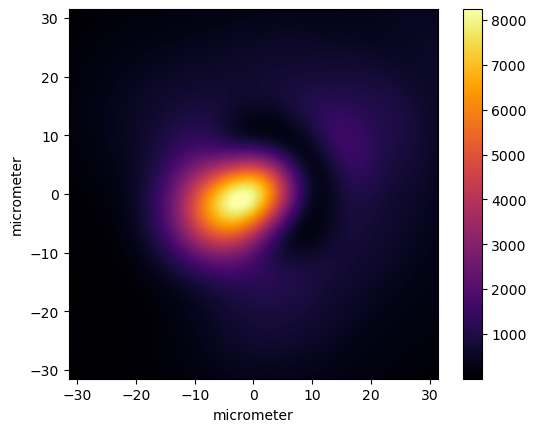

In [20]:
# Reset the pupils (to clear the previous case)
optics.pupils = []

# Generate and add the pupil functions
for wvl, wfe_rms_pct_ansi in wfe_rms_data.items():

    # optical path difference
    opd_mono = zernike_opd(
        wvl * wfe_rms_pct_ansi, optics.params.aperture_diameter, grid
    )

    optics.add_pupil_func(wvl, opd_mono)

# Generate the PSF
psf_poly = optics.psf(ref_wvl, psf_dx, psf_samples=psf_samples, with_units=True)

# plot2d has fixed units corresponding to that of dx
# PSF plane definition has units of microns
psf_poly.plot2d(xlim=(-xlim, xlim), log=False, axis_labels=(xlim.u,xlim.u))

The PSF exhibits marked differences to the monochromatic case, though they are more evident when log scale is turned on.

## Bonus: MTF Plots

As a bonus, we can plot the MTF for both cases to illustrate what this all means for image contrast. We will take a slice in x and y directions, and only in one axis.

We can define `MTF_Model_1D` objects for each slice to be able to plot them easily.

Primarily driven by defocus, the X and Y axis MTF plots differ visibly. While not clear due to the complex interaction of the "made-up" WFE RMS coefficients, the monochromatic case offers slightly better MTF, particularly in the X direction.

/home/egemen/miniforge3/envs/opticks/lib/python3.12/site-packages/scipy/interpolate/_cubic.py:32: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x, y = map(np.asarray, (x, y))


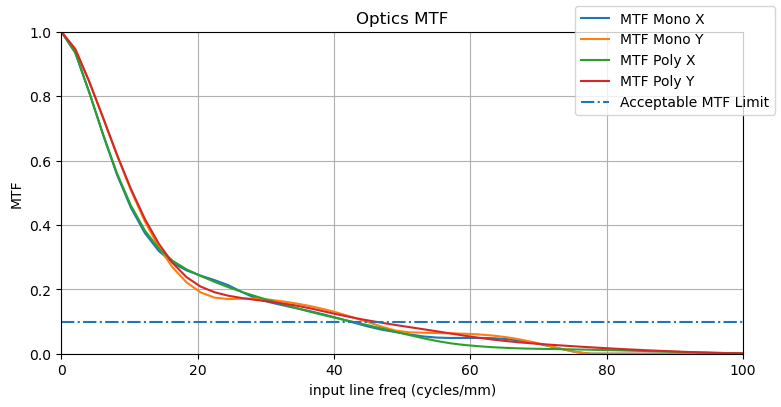

In [21]:
from opticks.perf_model.mtf import MTF_Model_1D, MTF_Plot_1D, psf_to_mtf

# convert 2D PSF to 2D MTF
mtf_2d_mono = psf_to_mtf(psf_mono, with_units=True)
mtf_2d_poly = psf_to_mtf(psf_poly, with_units=True)

# take slices to retrieve 1D MTF
mtf_mono_x = MTF_Model_1D.from_mtf_2d(mtf_2d_mono, "x")
mtf_mono_y = MTF_Model_1D.from_mtf_2d(mtf_2d_mono, "y")
mtf_poly_x = MTF_Model_1D.from_mtf_2d(mtf_2d_poly, "x")
mtf_poly_y = MTF_Model_1D.from_mtf_2d(mtf_2d_poly, "y")

# plot the MTF data
mtf_plot = MTF_Plot_1D()

mtf_plot_list = {
    "MTF Mono X": mtf_mono_x,
    "MTF Mono Y": mtf_mono_y,
    "MTF Poly X": mtf_poly_x,
    "MTF Poly Y": mtf_poly_y,
}
input_line_freq = np.linspace(0, 100, 50)

# populate the mtf plot with the models
mtf_plot.populate_plot(input_line_freq, mtf_plot_list)

# set MTF plot style tweaks
mtf_plot.set_plot_style(x_max=input_line_freq.max(), title="Optics MTF")